<a href="https://colab.research.google.com/github/ckkissane/deep_learning_curriculum/blob/scaling-laws/solutions/2_Scaling_Laws.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perform your own study of scaling laws for MNIST.

## Write a script to train a small CNN on MNIST, or find one you have written previously.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [2]:
def set_seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed(3407)

In [3]:
batch_size = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.Compose([
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                          download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
#Defining the small CNN
class ConvNet(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, kernel_size=3)
        self.fc = nn.Linear(192, 10)
        self.dropout = nn.Dropout(dropout)

        self.num_params = sum(p.numel() for p in self.parameters())
        print(f"num params: {self.num_params}")

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, 192)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [6]:
model = ConvNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01)

num params: 1960


In [7]:
def train(model, optimizer):
    model.train()
    print(f"training model with {model.num_params} parameters")
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for it, (images, labels) in pbar:  
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
            
        loss.backward()
        optimizer.step()

        pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")

train(model, optimizer)

training model with 1960 parameters


iter 468: train loss 0.18149: 100%|██████████| 469/469 [00:21<00:00, 21.91it/s]


In [8]:
def test(model):
    model.eval()
    print(f"testing model with {model.num_params} parameters")
    with torch.no_grad():
        correct = 0
        total = 0
        test_loss = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        test_loss /= len(test_loader)
        print(f"test loss: {test_loss}")
        print(f"Accuracy of the network on the 10000 test images: {correct / total}")
        return test_loss, correct / total

test(model)

testing model with 1960 parameters
test loss: 0.13905101698599284
Accuracy of the network on the 10000 test images: 0.9577


(0.13905101698599284, 0.9577)

## Training for a single epoch only, vary the model size and dataset size. For the model size, multiply the width by powers of sqrt(2) (rounding if necessary - the idea is to vary the amount of compute used per forward pass by powers of 2). To reduce noise, use a few random seeds and always use the full validation set.

In [9]:
# modify CNN model to scale width by scaling_factor
class WideConvNet(nn.Module):
    def __init__(self, scaling_factor, dropout=0.0):
        super().__init__()
        self.scaling_factor = scaling_factor
        self.conv1 = nn.Conv2d(1, int(3 * scaling_factor), kernel_size=3)
        self.fc = nn.Linear(int(3 * scaling_factor) * 64, 10)
        self.dropout = nn.Dropout(dropout)

        self.num_params = sum(p.numel() for p in self.parameters())
        print(f"num params: {self.num_params}")

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, int(3 * self.scaling_factor) * 64)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Note: for learning rates, I'll use the rule of thumb from [Scaling Laws for Neural Language Models](https://arxiv.org/abs/2001.08361)

In [10]:
def LR(N):
    return 0.003239  + ((-0.0001395) * math.log(N))

In [ ]:
# now train / test different sized models to observe scaling laws
# scaling factors: 2^0, 2^1, 2^2, ... 
num_models = 5
num_trials = 5
params = [0] * num_models
test_loss = [0] * num_models
accuracy = [0] * num_models
for power in range(num_models):
    for _ in range(num_trials):
        model = WideConvNet(scaling_factor=2**power).to(device)
        loss_fn = nn.CrossEntropyLoss()
        learning_rate = LR(model.num_params)
        optimizer = Adam(model.parameters(), lr=learning_rate)
        train(model, optimizer)
        tloss, acc = test(model)
        test_loss[power] += tloss
        accuracy[power] += acc
        print("\n")
    test_loss[power] /= num_trials
    accuracy[power] /= num_trials
    params[power] = model.num_params

### Plot the amount of compute used (on a log scale) against validation loss. The compute-efficient frontier should follow an approximate power law (straight line on a log scale).

Note: I'll start with the number of parameters instead of compute used. I will study the compute-efficient frontier later in this notebook. 

In [12]:
data = {'params' : params, 'loss': test_loss, 'accuracy': accuracy} 
df = pd.DataFrame(data)
df['log params'] = np.log10(df['params'])
df['log loss'] = np.log10(df['loss'])
df

,params,loss,accuracy,log params,log loss
0,1960,0.243126,0.92808,3.292256,-0.614168
1,3910,0.168984,0.95040,3.592177,-0.772154
2,7810,0.109691,0.96670,3.892651,-0.959828
3,15610,0.084731,0.97374,4.193403,-1.071960
4,31210,0.078072,0.97598,4.494294,-1.107507


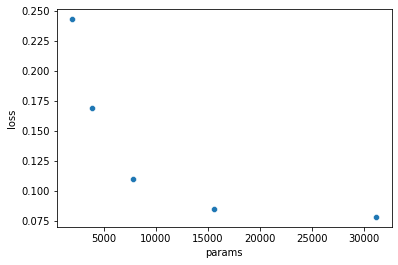

In [13]:
sns.scatterplot(data=df, x="params", y="loss");

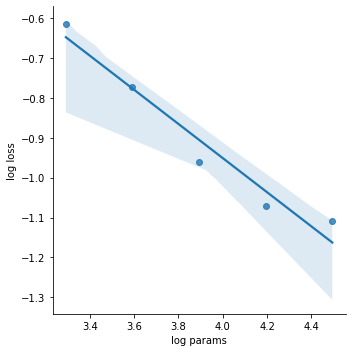

In [14]:
sns.lmplot(data=df, x="log params", y="log loss");

In [15]:
# analyze power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log params'],df['log loss'])
print(f"slope: {slope}, intercept: {intercept}")

slope: -0.4280199475069962, intercept: 0.7611391884722077


In [16]:
# Add power law to the dataset
df['power law'] = 10**intercept * df['params']**slope
df

,params,loss,accuracy,log params,log loss,power law
0,1960,0.243126,0.92808,3.292256,-0.614168,0.224899
1,3910,0.168984,0.95040,3.592177,-0.772154,0.167346
2,7810,0.109691,0.96670,3.892651,-0.959828,0.124453
3,15610,0.084731,0.97374,4.193403,-1.071960,0.092529
4,31210,0.078072,0.97598,4.494294,-1.107507,0.068785


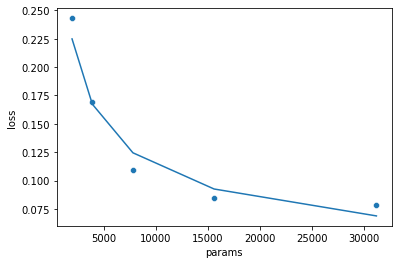

In [17]:
# fit loss curve with power law
sns.scatterplot(data=df, x="params", y="loss")
sns.lineplot(data=df, x="params", y='power law');

### How does validation accuracy behave?

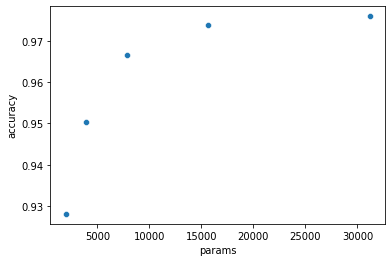

In [18]:
sns.scatterplot(data=df, x="params", y="accuracy");

## Study how the compute-efficient model size varies with compute. This should also follow an approximate power law. Try to estimate its exponent.

In [19]:
# train function that records train_loss and compute used every step
def get_compute_train_loss_data(model, max_epochs=1):
    loss_fn = nn.CrossEntropyLoss()
    learning_rate = LR(model.num_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    compute_used = []
    train_loss = []
    
    iters_per_epoch = len(train_loader)
    for epoch in range(max_epochs):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for it, (images, labels) in pbar:  
            model.train()
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")
            
            past_iters = epoch * iters_per_epoch
            # this uses C = 6NBS from the neural scaling laws paper
            compute_used.append(6 * model.num_params * batch_size * (it + 1 + past_iters))
            train_loss.append(loss.item())
    return compute_used, train_loss

num params: 1960


iter 468: train loss 0.19594: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]


num params: 3910


iter 468: train loss 0.17774: 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]


num params: 7810


iter 468: train loss 0.16085: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]


num params: 15610


iter 468: train loss 0.18333: 100%|██████████| 469/469 [00:14<00:00, 31.40it/s]


num params: 31210


iter 468: train loss 0.07163: 100%|██████████| 469/469 [00:14<00:00, 32.11it/s]


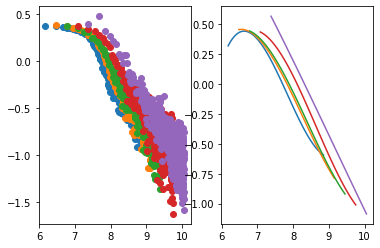

In [21]:
# function to train multiple models and record the data we care about
# also fits the loss curves and keeps track of the polynomials, so that we
# can use them to infer optimal model size later
def fit_loss_vs_compute(num_models, max_epochs=1):
    polys = []
    params = []
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for power in range(num_models):
        model = WideConvNet(scaling_factor=2 ** power).to(device)
        compute, train_loss = get_compute_train_loss_data(model, max_epochs)
        # fit curve
        x = np.log10(compute)
        y = np.log10(train_loss)
        z = np.polyfit(x, y, 3)
        f = np.poly1d(z)

        polys.append(f) 
        params.append(model.num_params)

        # plot log train_loss vs log compute
        x_new = np.linspace(x[0], x[-1], 50)
        y_new = f(x_new)
    
        ax1.scatter(x, y)
        ax2.plot(x_new, y_new)
    plt.show()
    return polys, params

polys, params = fit_loss_vs_compute(num_models=5, max_epochs=1)

In [25]:
# for a given compute value, pick the model with the minimum loss at that point
computes = []
sizes = []
for c in np.linspace(7, 11, 10):
    computes.append(c)
    optimal_size = None
    min_so_far = float('inf')
    for poly, size in zip(polys, params):
        if poly(c) < min_so_far:
            optimal_size = size
            min_so_far = poly(c)
    sizes.append(optimal_size)

In [26]:
data = {'log compute': computes, 'params': sizes}
df = pd.DataFrame(data)
df['log params'] = np.log10(df['params'])
df.head()

,log compute,params,log params
0,7.000000,1960,3.292256
1,7.444444,1960,3.292256
2,7.888889,1960,3.292256
3,8.333333,1960,3.292256
4,8.777778,3910,3.592177


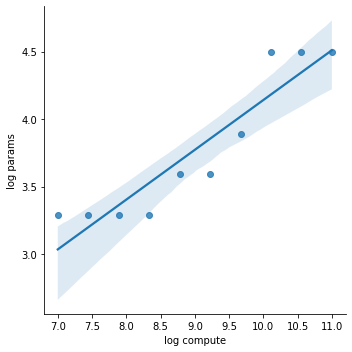

In [27]:
sns.lmplot(data=df, x='log compute', y='log params');

In [28]:
# analyze N_opt(C) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log compute'],df['log params'])
print(f"slope: {slope}, intercept: {intercept}")

slope: 0.3687814981506611, intercept: 0.4538575306531434


## For the dataset size, multiply the fraction of the full dataset used by powers of 2 (i.e. 1, 1/2, 1/4, ...). To reduce noise, use a few random seeds and always use the full validation set.

In [29]:
# train function that will use dataset of size len(train_dataset) // scaling_factor
def train_subset(model, optimizer, scaling_factor):
    model.train()
    print(f"training model with: {model.num_params} parameters")
    train_subset = Subset(train_dataset, range(0, len(train_dataset) // scaling_factor))
    train_loader_subset = DataLoader(dataset=train_subset,
                                    batch_size=batch_size,
                                    shuffle=True)
    print(f"dataset size: {len(train_loader_subset.dataset)}, {1/scaling_factor} of full train_dataset")
    pbar = tqdm(enumerate(train_loader_subset), total=len(train_loader_subset))
    for it, (images, labels) in pbar:  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
            
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")

In [ ]:
# now train / test multiple dataset sizes to observe dataset size scaling laws
num_datasets = 5
num_trials = 5
dataset_size = [0] * num_datasets
test_loss = [0] * num_datasets
accuracy = [0] * num_datasets
for power in range(num_datasets):
    for _ in range(num_trials):
        model = WideConvNet(scaling_factor=2**5).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR(model.num_params))
        train_subset(model, optimizer, scaling_factor=2**power)
        tloss, acc = test(model)
        test_loss[power] += tloss
        accuracy[power] += acc
        print("\n")
    dataset_size[power] = len(train_dataset) // 2**power
    params[power] = model.num_params
    test_loss[power] /= num_trials
    accuracy[power] /= num_trials

In [32]:
data = {'dataset_size' : dataset_size, 'loss': test_loss, 'accuracy': accuracy} 
df = pd.DataFrame(data)
df['log dataset_size'] = np.log10(df['dataset_size'])
df['log loss'] = np.log10(df['loss'])
df

,dataset_size,loss,accuracy,log dataset_size,log loss
0,60000,0.086652,0.97186,4.778151,-1.062222
1,30000,0.095734,0.97068,4.477121,-1.018935
2,15000,0.162281,0.95238,4.176091,-0.789733
3,7500,0.255476,0.92558,3.875061,-0.592650
4,3750,0.376398,0.88470,3.574031,-0.424353


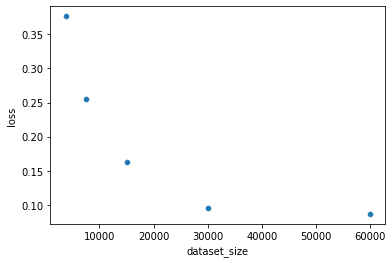

In [33]:
sns.scatterplot(data=df, x="dataset_size", y="loss");

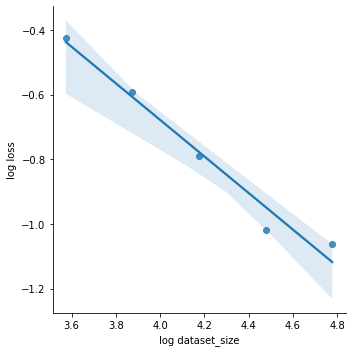

In [34]:
sns.lmplot(data=df, x="log dataset_size", y="log loss");

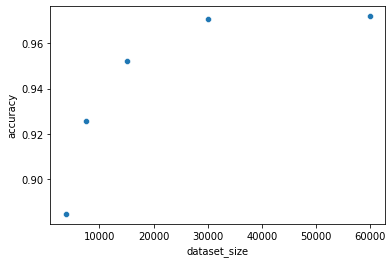

In [35]:
sns.scatterplot(data=df, x="dataset_size", y="accuracy");

In [36]:
# analyze L(D) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log dataset_size'],df['log loss'])
print(f"slope: {slope}, intercept: {intercept}")

slope: -0.5653998722049364, intercept: 1.5835829435122517


## Repeat your entire experiment with 20% dropout to see how this affects the scaling exponents.

First, parameter scaling laws

In [ ]:
# now train / test all models to observe scaling laws
# scaling factors: 2^0, 2^1, 2^2, ... 
num_models = 5
num_trials = 5
params = [0] * num_models
test_loss = [0] * num_models
accuracy = [0] * num_models
for power in range(num_models):
    for _ in range(num_trials):
        model = WideConvNet(scaling_factor=2**power, dropout=0.2).to(device)
        loss_fn = nn.CrossEntropyLoss()
        learning_rate = LR(model.num_params)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        train(model, optimizer)
        tloss, acc = test(model)
        test_loss[power] += tloss
        accuracy[power] += acc
        print("\n")
    test_loss[power] /= num_trials
    accuracy[power] /= num_trials
    params[power] = model.num_params

In [38]:
data = {'params' : params, 'loss': test_loss, 'accuracy': accuracy} 
df = pd.DataFrame(data)
df['log params'] = np.log10(df['params'])
df['log loss'] = np.log10(df['loss'])
df

,params,loss,accuracy,log params,log loss
0,1960,0.240611,0.93194,3.292256,-0.618684
1,3910,0.173246,0.94998,3.592177,-0.761338
2,7810,0.115649,0.96528,3.892651,-0.936858
3,15610,0.092832,0.97154,4.193403,-1.032302
4,31210,0.081124,0.97406,4.494294,-1.090852


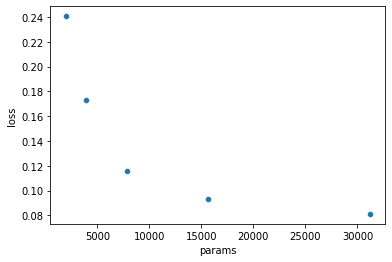

In [39]:
sns.scatterplot(data=df, x="params", y="loss");

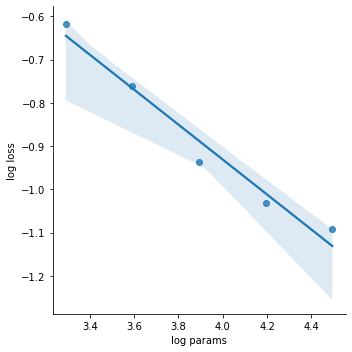

In [40]:
sns.lmplot(data=df, x="log params", y="log loss");

In [41]:
# analyze L(N) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log params'],df['log loss'])
print(f"slope: {slope}, intercept: {intercept}")

slope: -0.4043452945629377, intercept: 0.6860917649644679


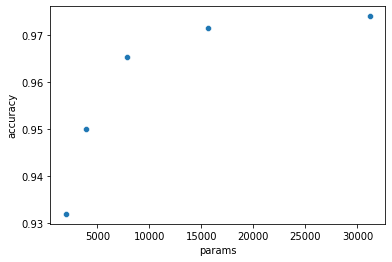

In [42]:
sns.scatterplot(data=df, x="params", y="accuracy")

Compute-efficient frontier / optimal model size scaling laws

In [43]:
# train function that records loss vs compute
def get_compute_train_loss_data(model, max_epochs=1):
    loss_fn = nn.CrossEntropyLoss()
    learning_rate = LR(model.num_params)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    compute_used = []
    train_loss = []
    
    iters_per_epoch = len(train_loader)
    for epoch in range(max_epochs):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for it, (images, labels) in pbar:  
            model.train()
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")
            
            past_iters = epoch * iters_per_epoch
            # this uses C = 6NBS from the neural scaling laws paper
            compute_used.append(6 * model.num_params * batch_size * (it + 1 + past_iters))
            train_loss.append(loss.item())
    return compute_used, train_loss

num params: 1960


iter 468: train loss 0.52373: 100%|██████████| 469/469 [00:14<00:00, 33.03it/s]


num params: 3910


iter 468: train loss 0.17987: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]


num params: 7810


iter 468: train loss 0.19875: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]


num params: 15610


iter 468: train loss 0.10518: 100%|██████████| 469/469 [00:14<00:00, 33.36it/s]


num params: 31210


iter 468: train loss 0.06962: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]


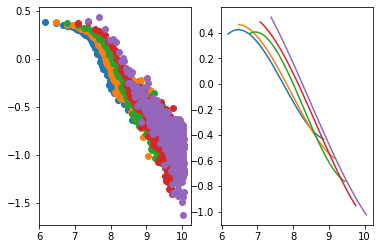

In [45]:
# function to train multiple models and record the data we care about
# also fits the loss curves and keeps track of the polynomials, so that we
# can use them to infer optimal model size later
def plot_loss_vs_train_compute(num_models, max_epochs=1):
    df = pd.DataFrame()
    funcs = []
    params = []
    fig, (ax1, ax2) = plt.subplots(1, 2)
    for power in range(num_models):
        temp_df = pd.DataFrame()
        model = WideConvNet(scaling_factor=2**power, dropout=0.2).to(device)
        compute, train_loss = get_compute_train_loss_data(model, max_epochs)
        temp_df['compute'] = compute
        temp_df['train_loss'] = train_loss
        temp_df['log compute'] = np.log10(compute)
        temp_df['log train_loss'] = np.log10(train_loss)
        temp_df['modelsize'] = model.num_params
        # fit curve
        x = temp_df['log compute'].values
        y = temp_df['log train_loss'].values
        z = np.polyfit(x, y, 3)
        f = np.poly1d(z)

        funcs.append(f) 
        params.append(model.num_params)

        # plot log train_loss vs log compute
        x_new = np.linspace(x[0], x[-1], 50)
        y_new = f(x_new)
    
        ax2.plot(x_new, y_new)
        ax1.scatter(np.log10(compute), np.log10(train_loss))
        df = df.append(temp_df)
    plt.show()
    return df, funcs, params

df, polys, params = plot_loss_vs_train_compute(num_models=5, max_epochs=1)

In [46]:
# for a given compute value, pick the model with the minimum loss at that point
computes = []
sizes = []
for c in np.linspace(7, 11, 10):
    computes.append(c)
    optimal_size = None
    min_so_far = float('inf')
    for poly, size in zip(polys, params):
        if poly(c) < min_so_far:
            optimal_size = size
            min_so_far = poly(c)
    sizes.append(optimal_size)

In [48]:
data = {'log compute': computes, 'params': sizes}
df = pd.DataFrame(data)
df['log params'] = np.log10(df['params'])
df.head()

,log compute,params,log params
0,7.000000,1960,3.292256
1,7.444444,1960,3.292256
2,7.888889,1960,3.292256
3,8.333333,1960,3.292256
4,8.777778,7810,3.892651


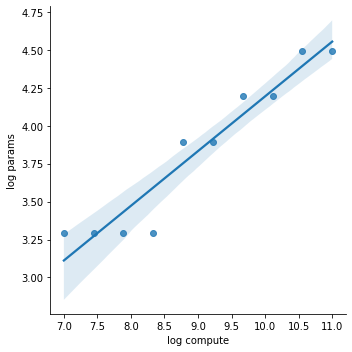

In [49]:
sns.lmplot(data=df, x='log compute', y='log params');

In [50]:
# analyze N_opt(C) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log compute'],df['log params'])
print(f"slope: {slope}, intercept: {intercept}")

slope: 0.3605696974171262, intercept: 0.587844692909465


Finally, dataset size scaling laws

In [51]:
# new train function that will take dataset scaling_factor arg
# we use dataset size of len(train_dataset) // scaling_factor
# we will use powers of 2: 1, 2, 4, 8, 16
def train_subset(model, optimizer, scaling_factor):
    model.train()
    print(f"training model with: {model.num_params} parameters")
    train_subset = torch.utils.data.Subset(train_dataset, range(0, len(train_dataset) // scaling_factor))
    train_loader_subset = torch.utils.data.DataLoader(dataset=train_subset,
                                           batch_size=batch_size,
                                           shuffle=True)
    print(f"dataset size: {len(train_loader_subset.dataset)}, {1/scaling_factor} of full train_dataset")
    pbar = tqdm(enumerate(train_loader_subset), total=len(train_loader_subset))
    for it, (images, labels) in pbar:  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
            
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"iter {it}: train loss {loss.item():.5f}")

In [52]:
model = WideConvNet(scaling_factor=2**5, dropout=0.2).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR(model.num_params))

num params: 62410


In [ ]:
# now train / test multiple models to observe dataset size scaling laws
# scaling factors: sqrt(2)^0, sqrt(2)^1, ..., sqrt(2)^4
num_datasets = 5
num_trials = 5
dataset_size = [0] * num_datasets
test_loss = [0] * num_datasets
accuracy = [0] * num_datasets
for power in range(num_datasets):
    for _ in range(num_trials):
        model = WideConvNet(scaling_factor=2**5, dropout=0.2).to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR(model.num_params))
        train_subset(model, optimizer, scaling_factor=2**power)
        tloss, acc = test(model)
        test_loss[power] += tloss
        accuracy[power] += acc
        print("\n")
    dataset_size[power] = len(train_dataset) // 2**power
    params[power] = model.num_params
    test_loss[power] /= num_trials
    accuracy[power] /= num_trials

In [54]:
data = {'dataset_size' : dataset_size, 'loss': test_loss, 'accuracy': accuracy} 
df = pd.DataFrame(data)
df['log dataset_size'] = np.log10(df['dataset_size'])
df['log loss'] = np.log10(df['loss'])
df

,dataset_size,loss,accuracy,log dataset_size,log loss
0,60000,0.079314,0.97430,4.778151,-1.100649
1,30000,0.105308,0.96860,4.477121,-0.977537
2,15000,0.154984,0.95578,4.176091,-0.809714
3,7500,0.256372,0.92566,3.875061,-0.591129
4,3750,0.379217,0.88540,3.574031,-0.421113


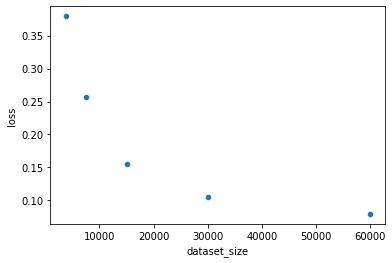

In [55]:
sns.scatterplot(data=df, x="dataset_size", y="loss")

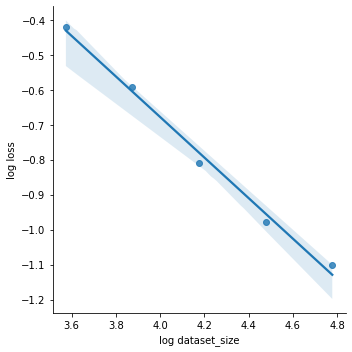

In [56]:
sns.lmplot(data=df, x="log dataset_size", y="log loss");

In [57]:
# analyze L(D) power law
slope, intercept, r_value, p_value, std_err = stats.linregress(df['log dataset_size'],df['log loss'])
print(f"slope: {slope}, intercept: {intercept}")

slope: -0.5798363818516615, intercept: 1.641421280651655


In this run, it looks like the dropout didn't make much of a difference...